In [1]:
# Imports

import torch
import torch.nn as nn
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
# --- Load Model Class from Training ---
from train_vae import VAE, MelDataset

In [15]:

# --- Config ---
CHECKPOINT_PATH = "../checkpoints/vae_lat256_spk64_ep10_beta100.pt"  # beta=0.1 ⇒ 100
NUM_SPEAKERS = 110
LATENT_DIM = 256
SPEAKER_EMB_DIM = 64
MEL_LENGTH = 400
SAVE_PATH = "./generated_mels"

os.makedirs(SAVE_PATH, exist_ok=True)



In [14]:
import torch

checkpoint = torch.load("../checkpoints/vae_lat256_spk64_ep10_beta100.pt", map_location="cpu")
print(type(checkpoint))
print(checkpoint.keys() if isinstance(checkpoint, dict) else "Not a dict")


for k, v in checkpoint.items():
    print(f"{k}: {v.shape}")


<class 'collections.OrderedDict'>
odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'to_mu.weight', 'to_mu.bias', 'to_logvar.weight', 'to_logvar.bias', 'speaker_embed.weight', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias'])
encoder.0.weight: torch.Size([128, 80, 3])
encoder.0.bias: torch.Size([128])
encoder.2.weight: torch.Size([128, 128, 3])
encoder.2.bias: torch.Size([128])
to_mu.weight: torch.Size([256, 128])
to_mu.bias: torch.Size([256])
to_logvar.weight: torch.Size([256, 128])
to_logvar.bias: torch.Size([256])
speaker_embed.weight: torch.Size([110, 64])
decoder.0.weight: torch.Size([512, 320])
decoder.0.bias: torch.Size([512])
decoder.2.weight: torch.Size([32000, 512])
decoder.2.bias: torch.Size([32000])


In [16]:
# --- Load Model ---
model = VAE(latent_dim=LATENT_DIM, speaker_emb_dim=SPEAKER_EMB_DIM, num_speakers=NUM_SPEAKERS)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location="cpu"))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv1d(80, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): AdaptiveAvgPool1d(output_size=1)
  )
  (to_mu): Linear(in_features=128, out_features=256, bias=True)
  (to_logvar): Linear(in_features=128, out_features=256, bias=True)
  (speaker_embed): Embedding(110, 64)
  (decoder): Sequential(
    (0): Linear(in_features=320, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=32000, bias=True)
    (3): Tanh()
  )
)

In [17]:
# --- Inference Function ---
def generate_mel(speaker_idx: int, z=None):
    if z is None:
        z = torch.randn(1, LATENT_DIM)
    speaker_id = torch.tensor([speaker_idx])
    with torch.no_grad():
        speaker_emb = model.speaker_embed(speaker_id)
        z_cat = torch.cat([z, speaker_emb], dim=-1)
        mel = model.decoder(z_cat).view(1, 80, MEL_LENGTH)
    return mel.squeeze().cpu()

In [18]:
# --- Example Inference ---
example_speaker = 5
mel_spec = generate_mel(example_speaker)

✅ Saved mel spectrogram to ./generated_mels\mel_speaker5.pt


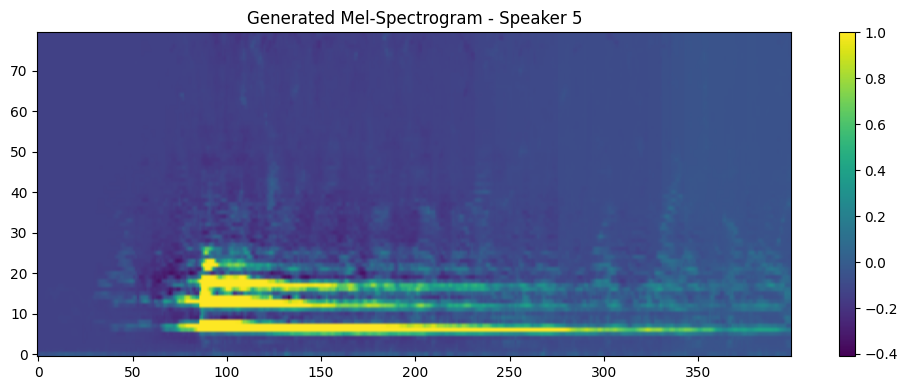

In [19]:
# --- Save and Plot ---
mel_path = os.path.join(SAVE_PATH, f"mel_speaker{example_speaker}.pt")
torch.save(mel_spec, mel_path)
print(f"✅ Saved mel spectrogram to {mel_path}")

plt.figure(figsize=(10, 4))
plt.imshow(mel_spec, aspect='auto', origin='lower')
plt.title(f"Generated Mel-Spectrogram - Speaker {example_speaker}")
plt.colorbar()
plt.tight_layout()
plt.show()